In [1]:
"""
Statistical Arbitrage Trading Strategy with Regime Detection
Clean, modular implementation following SOLID principles
"""

import os
import json
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

@dataclass
class TradingConfig:
    """Configuration parameters for trading strategy"""
    # Data parameters
    timescale: str = '5y'
    data_dir: str = 'data'
    etf_data_dir: str = 'etfdata'
    
    # Trading parameters
    initial_capital: float = 300000
    estimation_window: int = 60
    rolling_window: int = 30
    min_trading_days: int = 60
    
    # Signal thresholds
    long_entry_threshold: float = -1.25
    short_entry_threshold: float = 2.0
    long_exit_threshold: float = -0.5
    short_exit_threshold: float = 1.25
    
    # Risk management
    bid_ask_spread: float = 0.001
    market_impact: float = 0.0005
    max_reversion_days: float = 8.0
    trading_days_per_year: int = 252

# Initialize configuration
config = TradingConfig()

# Stock universe
COVID_TICKERS = [
    'UAL', 'DAL', 'LUV',  # Airlines
    'NFLX', 'MSFT', 'AAPL', 'AMZN',  # Tech
    'XOM', 'CVX', 'SLB', 'COP',  # Energy
    'JPM', 'BAC', 'WFC', 'C',  # Banks
    'WMT', 'TGT', 'COST', 'HD',  # Retail
    'CCL', 'MAR',  # Travel
    'MRNA', 'PFE', 'JNJ'  # Pharma
]

ETF_TICKERS = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']

SECTOR_MAPPING = {
    'Communication Services': 'XLC', 'Consumer Discretionary': 'XLY', 
    'Consumer Staples': 'XLP', 'Energy': 'XLE', 'Financials': 'XLF',
    'Health Care': 'XLV', 'Industrials': 'XLI', 'Materials': 'XLB',
    'Real Estate': 'XLRE', 'Information Technology': 'XLK', 'Utilities': 'XLU'
}

In [2]:
class DataFetcher:
    """Handles all data fetching operations"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
    
    def fetch_price_data(self, tickers: List[str], data_dir: str) -> None:
        """Fetch and save price data for given tickers"""
        os.makedirs(data_dir, exist_ok=True)
        
        for ticker in tickers:
            try:
                print(f"Downloading {ticker}...")
                stock = yf.Ticker(ticker)
                hist = stock.history(period=self.config.timescale)
                
                if hist.empty:
                    print(f"No data found for {ticker}")
                    continue
                
                data_list = self._format_price_data(hist, ticker)
                self._save_to_json(data_list, ticker, data_dir)
                print(f"Saved {len(data_list)} days of data for {ticker}")
                
            except Exception as e:
                print(f"Error downloading {ticker}: {e}")
    
    def _format_price_data(self, hist: pd.DataFrame, ticker: str) -> List[Dict]:
        """Convert Yahoo Finance data to standardized format"""
        data_list = []
        
        for i, (date, row) in enumerate(hist.iterrows()):
            change_percent = 0
            if i > 0:
                prev_close = hist.iloc[i-1]['Close']
                change_percent = ((row['Close'] - prev_close) / prev_close) * 100
            
            daily_data = {
                "close": round(row['Close'], 4),
                "high": round(row['High'], 4),
                "low": round(row['Low'], 4),
                "open": round(row['Open'], 4),
                "volume": int(row['Volume']),
                "symbol": ticker,
                "date": date.strftime('%Y-%m-%d'),
                "changePercent": round(change_percent, 6)
            }
            data_list.append(daily_data)
        
        return data_list
    
    def _save_to_json(self, data: List[Dict], ticker: str, data_dir: str) -> None:
        """Save data to JSON file"""
        filename = f'{data_dir}/{ticker}.json'
        with open(filename, 'w') as f:
            json.dump(data, f, indent=2)

# Fetch data
fetcher = DataFetcher(config)
fetcher.fetch_price_data(COVID_TICKERS, config.data_dir)
fetcher.fetch_price_data(ETF_TICKERS, config.etf_data_dir)

Saved 1256 days of data for UAL
Saved 1256 days of data for DAL
Saved 1256 days of data for LUV
Saved 1256 days of data for NFLX
Saved 1256 days of data for MSFT
Saved 1256 days of data for AAPL
Saved 1256 days of data for AMZN
Saved 1256 days of data for XOM
Saved 1256 days of data for CVX
Saved 1256 days of data for SLB
Saved 1256 days of data for COP
Saved 1256 days of data for JPM
Saved 1256 days of data for BAC
Saved 1256 days of data for WFC
Saved 1256 days of data for C
Saved 1256 days of data for WMT
Saved 1256 days of data for TGT
Saved 1256 days of data for COST
Saved 1256 days of data for HD
Saved 1256 days of data for CCL
Saved 1256 days of data for MAR
Saved 1256 days of data for MRNA
Saved 1256 days of data for PFE
Saved 1256 days of data for JNJ
Saved 1256 days of data for XLC
Saved 1256 days of data for XLY
Saved 1256 days of data for XLP
Saved 1256 days of data for XLE
Saved 1256 days of data for XLF
Saved 1256 days of data for XLV
Saved 1256 days of data for XLI
Saved

In [3]:
class MarketDataProcessor:
    """Processes market data for trading strategy"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
        self.sp500_data = self._get_sp500_data()
    
    def _get_sp500_data(self) -> pd.DataFrame:
        """Get S&P 500 constituent data"""
        tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        return tables[0]
    
    def load_returns_data(self, data_dir: str) -> Tuple[np.ndarray, Dict, List]:
        """Load and process returns data from JSON files"""
        folder = os.listdir(data_dir)
        ticker_to_index = {v: k for k, v in self.sp500_data['Symbol'].to_dict().items()}
        
        ticker_map = {}
        returns = []
        dates = []
        offset = 0
        
        for n, filename in enumerate(folder):
            if filename.startswith('.'):
                offset += 1
                continue
            
            ticker = filename.split('.json')[0]
            
            # Skip tickers not in S&P 500 (except ETFs)
            if ticker not in ETF_TICKERS and ticker not in ticker_to_index:
                print(f"Skipping {ticker} - not in current S&P 500")
                offset += 1
                continue
            
            with open(f'{data_dir}/{filename}', 'r') as file:
                data = json.load(file)
            
            # Extract returns (skip first day)
            ticker_returns = [day['changePercent'] * 100 for day in data][1:]
            
            # Map ticker to sector
            if ticker not in ETF_TICKERS:
                sector = self.sp500_data['GICS Sector'][ticker_to_index[ticker]]
                sector_etf = SECTOR_MAPPING[sector]
                ticker_map[n - offset] = (ticker, sector_etf)
            else:
                ticker_map[n - offset] = ticker
            
            ticker_map[ticker] = n - offset
            returns.append(ticker_returns)
            dates.append([day['date'] for day in data])
        
        # Convert to numpy array
        return_matrix = np.array(returns)
        return return_matrix, ticker_map, dates

# Process data
processor = MarketDataProcessor(config)
returns, ticker_map, dates = processor.load_returns_data(config.data_dir)
etf_returns, etf_map, _ = processor.load_returns_data(config.etf_data_dir)

print(f"Loaded {len(returns)} stocks and {len(etf_returns)} ETFs")

Loaded 24 stocks and 11 ETFs


In [4]:
class MeanReversionModel:
    """Ornstein-Uhlenbeck mean reversion model"""
    
    def estimate_parameters(self, residuals: np.ndarray) -> Tuple[float, float]:
        """Estimate mean reversion parameters using OU process"""
        cumulative_residuals = np.cumsum(residuals)
        t = len(cumulative_residuals) - 1
        
        X_t = cumulative_residuals[:-1].reshape(-1, 1)
        X_t1 = cumulative_residuals[1:].reshape(-1, 1)
        
        model = LinearRegression(fit_intercept=True)
        model.fit(X_t, X_t1)
        
        beta = model.coef_[0][0]
        alpha = model.intercept_[0]
        
        # Handle numerical issues
        if beta > 1:
            beta = 0.9672
        
        # Calculate mean reversion speed and signal
        kappa = -np.log10(max(beta, 1e-10)) * config.trading_days_per_year
        
        # Calculate equilibrium and volatility
        equilibrium = alpha / (1 - beta)
        epsilon = X_t1 - alpha - beta * X_t
        sigma = np.sqrt(np.var(epsilon) / (1 - beta**2))
        
        # Generate trading signal
        current_level = cumulative_residuals[-1]
        raw_signal = (current_level - equilibrium) / sigma
        adjusted_signal = raw_signal - (alpha / (kappa * sigma))
        
        return kappa, adjusted_signal


class AdaptiveHedgeRatioCalculator:
    """Calculates adaptive hedge ratios using rolling regressions"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
    
    def calculate_hedge_ratios(self, stock_returns: np.ndarray, etf_returns: np.ndarray, 
                              ticker_map: Dict, etf_map: Dict) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate adaptive hedge ratios and residuals"""
        n_stocks = len(stock_returns)
        period = stock_returns.shape[1]
        
        hedge_ratios = np.zeros((n_stocks, 1))
        residuals = np.zeros((n_stocks, period))
        
        for stock_idx in range(n_stocks):
            if isinstance(ticker_map[stock_idx], tuple):
                sector_etf = ticker_map[stock_idx][1]
                etf_idx = etf_map[sector_etf]
                sector_returns = etf_returns[etf_idx]
                
                stock_residuals = []
                ratios = []
                
                for t in range(period):
                    window_start, window_end = self._get_window_bounds(t, period)
                    
                    # Rolling regression for adaptive hedge ratio
                    X_window = sector_returns[window_start:window_end].reshape(-1, 1)
                    y_window = stock_returns[stock_idx][window_start:window_end].reshape(-1, 1)
                    
                    if len(X_window) > 1:
                        model = LinearRegression().fit(X_window, y_window)
                        current_ratio = model.coef_[0][0]
                    else:
                        current_ratio = 1.0
                    
                    ratios.append(current_ratio)
                    
                    # Calculate residual using current ratio
                    residual = stock_returns[stock_idx][t] - current_ratio * sector_returns[t]
                    stock_residuals.append(residual)
                
                hedge_ratios[stock_idx] = ratios[-1]  # Use most recent ratio
                residuals[stock_idx] = np.array(stock_residuals)
        
        return hedge_ratios, residuals
    
    def _get_window_bounds(self, t: int, period: int) -> Tuple[int, int]:
        """Get rolling window bounds"""
        if t < self.config.rolling_window:
            return 0, t + 1
        else:
            return t - self.config.rolling_window + 1, t + 1

# Initialize models
mean_reversion_model = MeanReversionModel()
hedge_calculator = AdaptiveHedgeRatioCalculator(config)

In [5]:
class TradingSignalGenerator:
    """Generates trading signals based on mean reversion"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
    
    def generate_signals(self, hedge_ratios: np.ndarray, residuals: np.ndarray) -> Tuple[List[float], List[float]]:
        """Generate kappa values and trading signals"""
        kappa_values = []
        signals = []
        
        for i in range(len(residuals)):
            kappa, signal = mean_reversion_model.estimate_parameters(residuals[i])
            kappa_values.append(kappa)
            signals.append(signal)
        
        return kappa_values, signals
    
    def filter_tradeable_stocks(self, kappa_values: List[float]) -> List[int]:
        """Filter stocks based on mean reversion speed"""
        max_kappa = self.config.trading_days_per_year / (self.config.estimation_window * 0.5)
        return [i for i, kappa in enumerate(kappa_values) if kappa < max_kappa]


class PositionManager:
    """Manages trading positions and portfolio construction"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
        self.positions = {}
        self.previous_portfolio = {}
    
    def update_positions(self, signals: List[float], filtered_stocks: List[int]) -> None:
        """Update positions based on signals"""
        for stock_idx, signal in enumerate(signals):
            can_trade = stock_idx in filtered_stocks
            current_position = self.positions.get(stock_idx, 0)
            
            # Exit logic
            if current_position != 0:
                should_exit = (
                    (current_position == 1 and signal > self.config.long_exit_threshold) or
                    (current_position == -1 and signal < self.config.short_exit_threshold) or
                    not can_trade
                )
                if should_exit:
                    self.positions[stock_idx] = 0
                    continue
            
            # Entry logic
            if current_position == 0 and can_trade:
                if signal < self.config.long_entry_threshold:
                    self.positions[stock_idx] = 1  # Long signal
                elif signal > self.config.short_entry_threshold:
                    self.positions[stock_idx] = -1  # Short signal
    
    def construct_portfolio(self, hedge_ratios: np.ndarray, ticker_map: Dict) -> Dict[str, float]:
        """Construct dollar-neutral portfolio"""
        active_positions = sum(1 for pos in self.positions.values() if pos != 0)
        if active_positions == 0:
            return {}
        
        position_size = self.config.initial_capital / active_positions
        portfolio = {}
        
        for stock_idx, direction in self.positions.items():
            if direction == 0 or stock_idx not in ticker_map:
                continue
            
            stock_ticker, etf_ticker = ticker_map[stock_idx]
            hedge_ratio = hedge_ratios[stock_idx][0]
            
            if direction == 1:  # Long stock, short ETF
                portfolio[stock_ticker] = position_size
                portfolio[etf_ticker] = portfolio.get(etf_ticker, 0) - (hedge_ratio * position_size)
            elif direction == -1:  # Short stock, long ETF
                portfolio[stock_ticker] = -position_size
                portfolio[etf_ticker] = portfolio.get(etf_ticker, 0) + (hedge_ratio * position_size)
        
        return portfolio
    
    def calculate_transaction_costs(self, portfolio: Dict[str, float]) -> float:
        """Calculate realistic transaction costs"""
        total_costs = 0
        cost_rate = self.config.bid_ask_spread + self.config.market_impact
        
        for ticker, position in portfolio.items():
            previous_position = self.previous_portfolio.get(ticker, 0)
            position_change = abs(position - previous_position)
            total_costs += position_change * cost_rate
        
        self.previous_portfolio = portfolio.copy()
        return total_costs

# Initialize trading components
signal_generator = TradingSignalGenerator(config)
position_manager = PositionManager(config)

In [6]:
class BacktestEngine:
    """Main backtesting engine"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
        self.results = {
            'daily_returns': [],
            'portfolio_history': [],
            'signal_history': [],
            'kappa_history': []
        }
    
    def run_backtest(self, returns: np.ndarray, etf_returns: np.ndarray, 
                    ticker_map: Dict, etf_map: Dict) -> Dict:
        """Run complete backtesting simulation"""
        n_days = returns.shape[1]
        
        for day in range(self.config.min_trading_days, n_days):
            daily_return = self._process_trading_day(
                day, returns, etf_returns, ticker_map, etf_map
            )
            self.results['daily_returns'].append(daily_return)
            
            if day % 100 == 0:
                print(f"Processed day {day}/{n_days}")
        
        return self._calculate_performance_metrics()
    
    def _process_trading_day(self, day: int, returns: np.ndarray, etf_returns: np.ndarray,
                           ticker_map: Dict, etf_map: Dict) -> float:
        """Process a single trading day"""
        # Extract window data
        start_day = day - self.config.estimation_window
        window_returns = returns[:, start_day:day]
        window_etf_returns = etf_returns[:, start_day:day]
        
        # Calculate hedge ratios and residuals
        hedge_ratios, residuals = hedge_calculator.calculate_hedge_ratios(
            window_returns, window_etf_returns, ticker_map, etf_map
        )
        
        # Generate signals
        kappa_values, signals = signal_generator.generate_signals(hedge_ratios, residuals)
        filtered_stocks = signal_generator.filter_tradeable_stocks(kappa_values)
        
        # Update positions and construct portfolio
        position_manager.update_positions(signals, filtered_stocks)
        portfolio = position_manager.construct_portfolio(hedge_ratios, ticker_map)
        
        # Calculate daily returns
        daily_return = self._calculate_portfolio_return(
            portfolio, returns[:, day], etf_returns[:, day], ticker_map, etf_map
        )
        
        # Store results
        self.results['signal_history'].append(signals)
        self.results['kappa_history'].append(kappa_values)
        self.results['portfolio_history'].append(portfolio)
        
        return daily_return
    
    def _calculate_portfolio_return(self, portfolio: Dict[str, float], 
                                  stock_returns: np.ndarray, etf_returns: np.ndarray,
                                  ticker_map: Dict, etf_map: Dict) -> float:
        """Calculate portfolio return for the day"""
        daily_return = 0
        
        for ticker, position in portfolio.items():
            if ticker in ETF_TICKERS:
                etf_idx = etf_map[ticker]
                return_pct = etf_returns[etf_idx] / 100
            else:
                stock_idx = ticker_map[ticker]
                return_pct = stock_returns[stock_idx] / 100
            
            daily_return += position * return_pct
        
        # Subtract transaction costs
        transaction_costs = position_manager.calculate_transaction_costs(portfolio)
        return daily_return - transaction_costs
    
    def _calculate_performance_metrics(self) -> Dict:
        """Calculate final performance metrics"""
        total_returns = np.array(self.results['daily_returns'])
        
        metrics = {
            'total_return': np.sum(total_returns),
            'percentage_return': (np.sum(total_returns) / self.config.initial_capital) * 100,
            'sharpe_ratio': (np.mean(total_returns) / np.std(total_returns)) * np.sqrt(self.config.trading_days_per_year),
            'daily_returns': total_returns,
            'signal_history': self.results['signal_history'],
            'kappa_history': self.results['kappa_history']
        }
        
        return metrics

# Run backtest
engine = BacktestEngine(config)
results = engine.run_backtest(returns, etf_returns, ticker_map, etf_map)

print(f"Total Return: ${results['total_return']:,.0f}")
print(f"Percentage Return: {results['percentage_return']:.2f}%")
print(f"Sharpe Ratio: {results['sharpe_ratio']:.3f}")

Processed day 100/1255
Processed day 200/1255
Processed day 300/1255
Processed day 400/1255
Processed day 500/1255
Processed day 600/1255
Processed day 700/1255
Processed day 800/1255
Processed day 900/1255
Processed day 1000/1255
Processed day 1100/1255
Processed day 1200/1255
Total Return: $6,278,795
Percentage Return: 2092.93%
Sharpe Ratio: 0.229


In [7]:
class PerformanceAnalyzer:
    """Analyzes strategy performance across market regimes"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
    
    def analyze_market_regimes(self, daily_returns: np.ndarray) -> Dict:
        """Analyze performance across COVID market regimes"""
        regimes = {
            'Pre-COVID (Jan-Feb 2020)': daily_returns[0:60],
            'COVID Crash (Mar-Jun 2020)': daily_returns[60:150],
            'Recovery (Jul 2020-Jun 2021)': daily_returns[150:400],
            'Post-Vaccine (Jul 2021-2024)': daily_returns[400:]
        }
        
        regime_stats = {}
        print("=== MARKET REGIME ANALYSIS ===")
        
        for regime_name, regime_returns in regimes.items():
            if len(regime_returns) > 0:
                stats = self._calculate_regime_stats(regime_returns)
                regime_stats[regime_name] = stats
                self._print_regime_stats(regime_name, stats)
        
        return regime_stats
    
    def _calculate_regime_stats(self, returns: np.ndarray) -> Dict:
        """Calculate statistics for a market regime"""
        total_return = np.sum(returns)
        mean_return = np.mean(returns)
        std_return = np.std(returns)
        sharpe = (mean_return / std_return) * np.sqrt(self.config.trading_days_per_year) if std_return > 0 else 0
        win_rate = len([x for x in returns if x > 0]) / len(returns)
        
        return {
            'total_return': total_return,
            'daily_mean': mean_return,
            'daily_std': std_return,
            'sharpe_ratio': sharpe,
            'win_rate': win_rate,
            'days': len(returns)
        }
    
    def _print_regime_stats(self, regime_name: str, stats: Dict) -> None:
        """Print formatted regime statistics"""
        print(f"\n{regime_name}:")
        print(f"  Days: {stats['days']}")
        print(f"  Total Return: ${stats['total_return']:,.0f}")
        print(f"  Daily Mean: ${stats['daily_mean']:,.0f}")
        print(f"  Sharpe Ratio: {stats['sharpe_ratio']:.3f}")
        print(f"  Win Rate: {stats['win_rate']:.1%}")
        print(f"  Volatility: ${stats['daily_std']:,.0f}")

# Analyze performance
analyzer = PerformanceAnalyzer(config)
regime_analysis = analyzer.analyze_market_regimes(results['daily_returns'])

=== MARKET REGIME ANALYSIS ===

Pre-COVID (Jan-Feb 2020):
  Days: 60
  Total Return: $-5,935,983
  Daily Mean: $-98,933
  Sharpe Ratio: -1.929
  Win Rate: 35.0%
  Volatility: $814,084

COVID Crash (Mar-Jun 2020):
  Days: 90
  Total Return: $-207,411
  Daily Mean: $-2,305
  Sharpe Ratio: -0.158
  Win Rate: 35.6%
  Volatility: $231,856

Recovery (Jul 2020-Jun 2021):
  Days: 250
  Total Return: $4,982,852
  Daily Mean: $19,931
  Sharpe Ratio: 0.969
  Win Rate: 50.0%
  Volatility: $326,629

Post-Vaccine (Jul 2021-2024):
  Days: 795
  Total Return: $7,439,337
  Daily Mean: $9,358
  Sharpe Ratio: 0.452
  Win Rate: 49.3%
  Volatility: $328,634


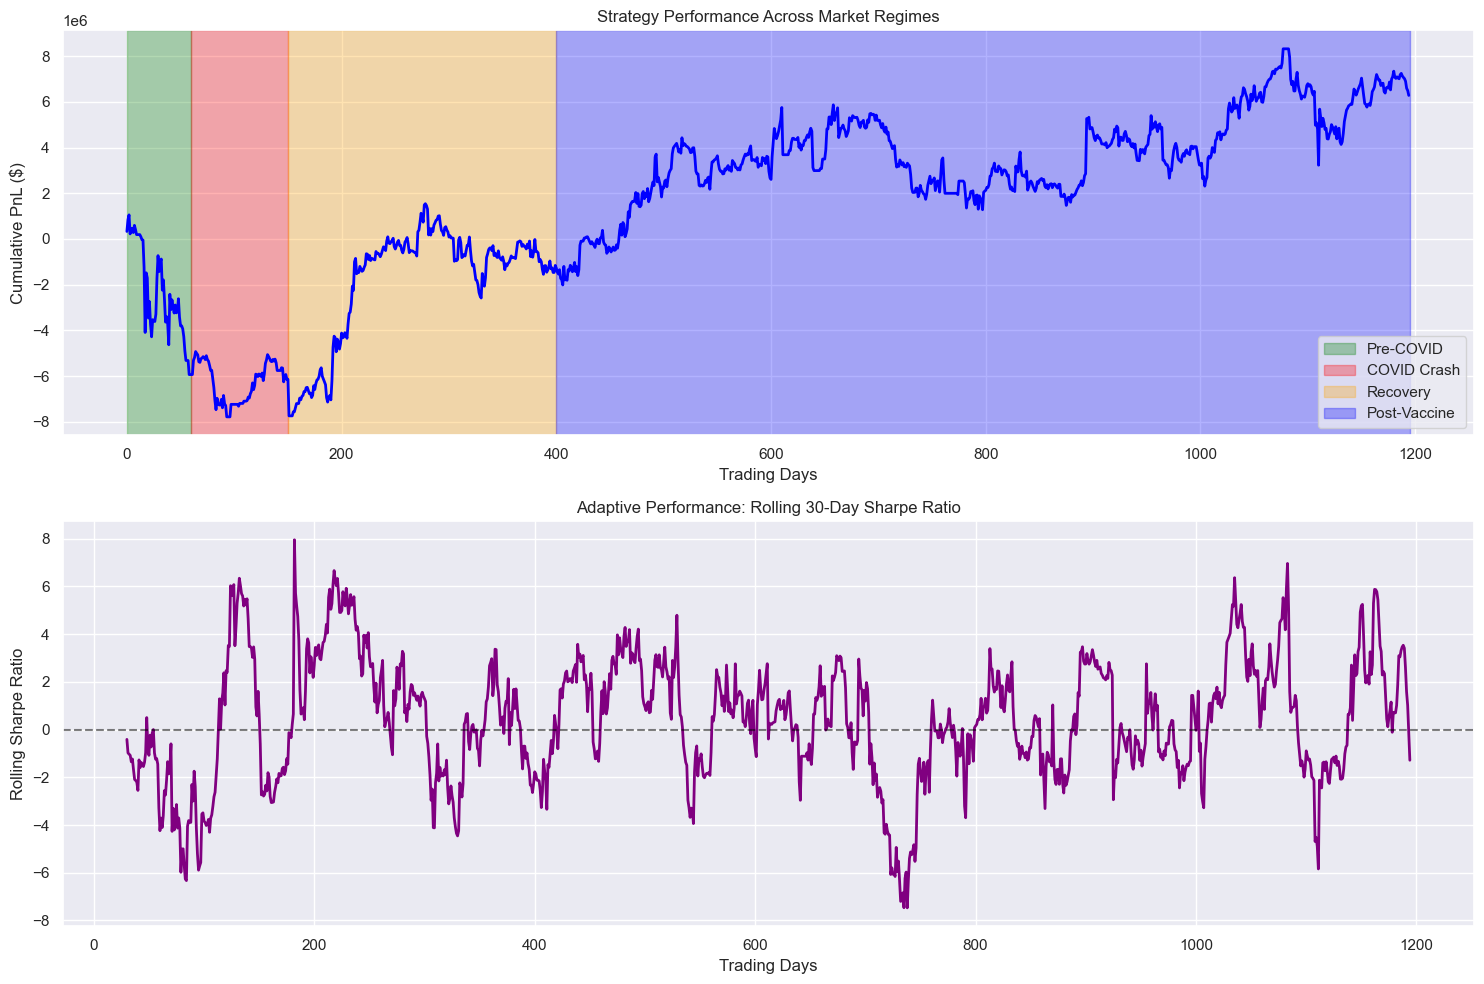

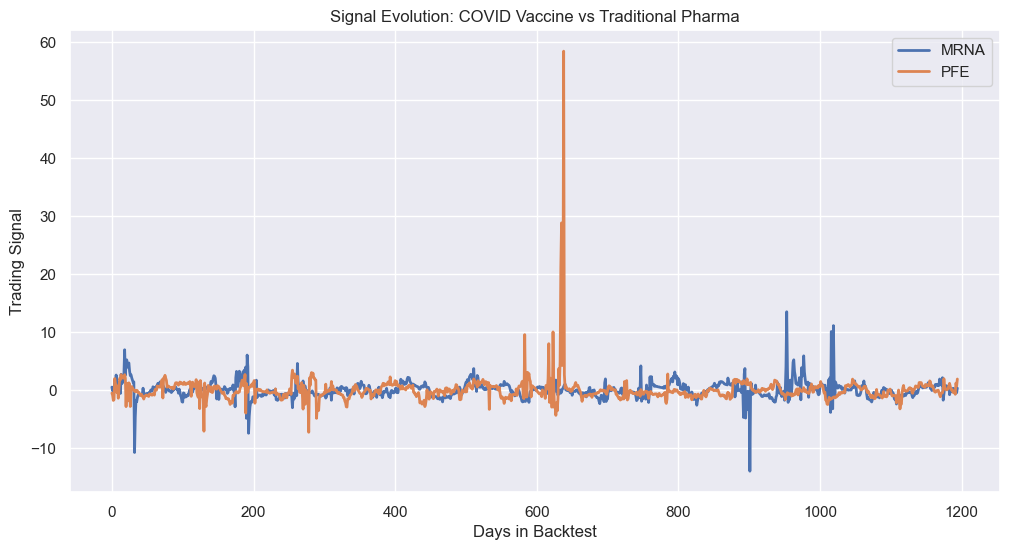

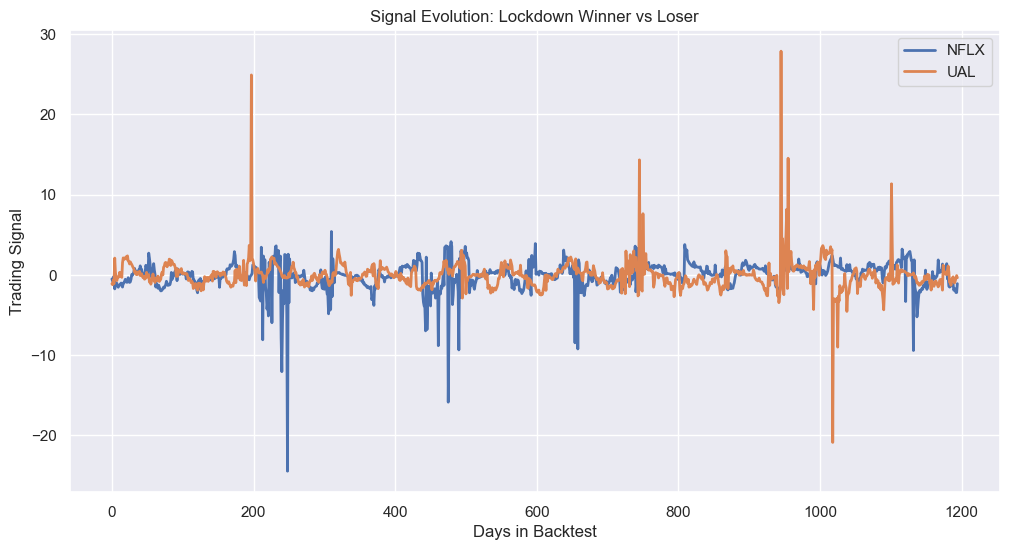

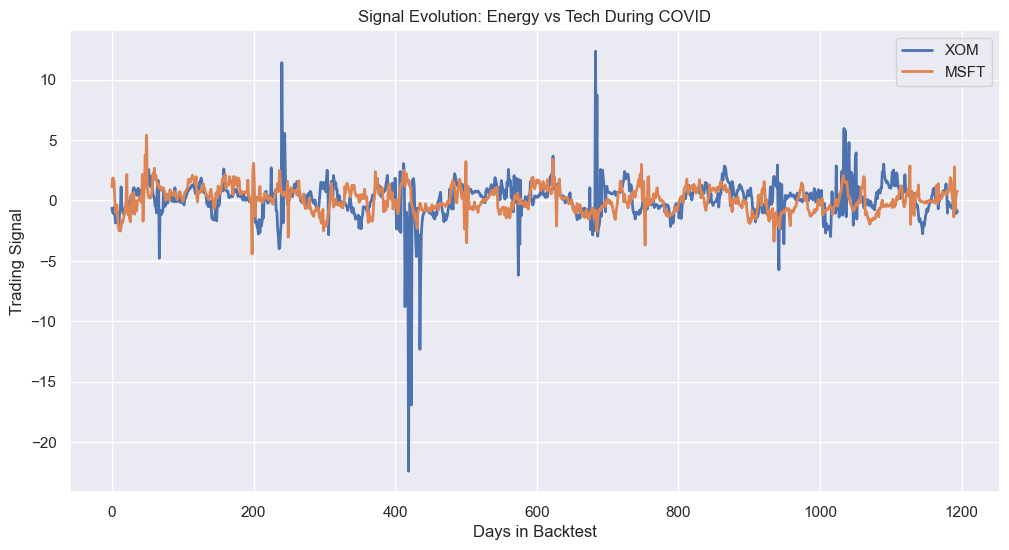

In [8]:
class StrategyVisualizer:
    """Creates visualizations for strategy analysis"""
    
    def __init__(self, config: TradingConfig):
        self.config = config
    
    def plot_cumulative_performance(self, daily_returns: np.ndarray) -> None:
        """Plot cumulative returns with regime highlighting"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot 1: Cumulative returns
        cumulative_returns = np.cumsum(daily_returns)
        ax1.plot(cumulative_returns, linewidth=2, color='blue')
        
        # Add regime highlighting
        ax1.axvspan(0, 60, alpha=0.3, color='green', label='Pre-COVID')
        ax1.axvspan(60, 150, alpha=0.3, color='red', label='COVID Crash')
        ax1.axvspan(150, 400, alpha=0.3, color='orange', label='Recovery')
        ax1.axvspan(400, len(daily_returns), alpha=0.3, color='blue', label='Post-Vaccine')
        
        ax1.set_title('Strategy Performance Across Market Regimes')
        ax1.set_xlabel('Trading Days')
        ax1.set_ylabel('Cumulative PnL ($)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Rolling Sharpe ratio
        window = 30
        rolling_sharpe = []
        for i in range(window, len(daily_returns)):
            period_returns = daily_returns[i-window:i]
            sharpe = (np.mean(period_returns) / np.std(period_returns)) * np.sqrt(252)
            rolling_sharpe.append(sharpe)
        
        ax2.plot(range(window, len(daily_returns)), rolling_sharpe, linewidth=2, color='purple')
        ax2.set_title('Adaptive Performance: Rolling 30-Day Sharpe Ratio')
        ax2.set_xlabel('Trading Days')
        ax2.set_ylabel('Rolling Sharpe Ratio')
        ax2.grid(True)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    def plot_signal_evolution(self, signal_history: List, ticker_map: Dict) -> None:
        """Plot signal evolution for key COVID stocks"""
        signal_df = pd.DataFrame(signal_history)
        
        # Key COVID comparison pairs
        comparisons = [
            ('MRNA', 'PFE', 'COVID Vaccine vs Traditional Pharma'),
            ('NFLX', 'UAL', 'Lockdown Winner vs Loser'),
            ('XOM', 'MSFT', 'Energy vs Tech During COVID')
        ]
        
        for stock1, stock2, title in comparisons:
            if stock1 in ticker_map and stock2 in ticker_map:
                fig, ax = plt.subplots(figsize=(12, 6))
                
                idx1 = ticker_map[stock1]
                idx2 = ticker_map[stock2]
                
                sns.lineplot(data=signal_df.iloc[:, idx1], label=f'{stock1}', linewidth=2)
                sns.lineplot(data=signal_df.iloc[:, idx2], label=f'{stock2}', linewidth=2)
                
                plt.xlabel('Days in Backtest')
                plt.ylabel('Trading Signal')
                plt.title(f'Signal Evolution: {title}')
                plt.legend()
                plt.show()

# Create visualizations
visualizer = StrategyVisualizer(config)
visualizer.plot_cumulative_performance(results['daily_returns'])
visualizer.plot_signal_evolution(results['signal_history'], ticker_map)